In [36]:
### using (7.64a), which f0*\bar{v*} + \bar{v'q'} equal m (v* mean vTEM)
# rewrite v'q' as def
# cal and plot all final fig in Lorenz and Harmann 2001
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.fftpack import fft,ifft,fftfreq
from scipy.interpolate import interp1d
import datetime 
from EOF import EOF
from scipy.fft import fft, ifft


In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [99]:
def get_vq(rh, pr):
    start = datetime.datetime.now()
    file  = f"HS_front_RH{rh}_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    
    dycore = Dycore(file)
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    
    Rd = 287
    cp = 1004
    g  = 9.81
    H  = 6800
    a  = 6.37122e6
    theta       = t * (ps / p)**(Rd/cp)
    sigma       = p / ps
    sigma_mean  = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    x           = np.linspace(-180,180,128)
    y           = np.linspace(-90,90,64)
    xd          = np.deg2rad(x)
    yd          = np.deg2rad(y)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
    day = int(np.size(u[:,0,0,0]))
    
    ### cal zonal anamoly
    # zonal mean
    Vzm     = np.nanmean(v, axis=3)
    Uzm     = np.nanmean(u, axis=3)
    THzm    = np.nanmean(theta, axis=3)
    # THvm = np.nanmean(theta, axis=1)#######
    Pzm     = np.nanmean(p, axis=3)
    Tzm     = np.nanmean(t, axis=3)
    # time mean
    Vzmtm   = np.nanmean(Vzm, axis=0)
    Uzmtm   = np.nanmean(Uzm, axis=0)
    THzmtm  = np.nanmean(THzm, axis=0)
    # THvmtm = np.nanmean(THvm, axis=0)#######
    Pzmtm   = np.nanmean(Pzm, axis=0)
    Tzmtm   = np.nanmean(Tzm, axis=0)
    # zonal anomoly
    Vza     = np.zeros(u.shape)
    Uza     = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Pza = np.zeros(u.shape)
    Tza = np.zeros(t.shape)
    for i in range(0,128):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
        Tza[:,:,:,i]     = t[:,:,:,i] - Tzm
    # cal momentum flux
    M     = Uza * Vza
    Mzmtm = np.nanmean(M, axis=(0,3))

    # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
    cy = np.cos(yd)
    cy [0] = np.nan
    cy [-1] = np.nan
    for i in range(1,64-1):
        Mzmtm[:,i] = cy[i]**0.5 * Mzmtm[:,i] ### weight

    # cal momentum flux convergence
    dmdy = np.zeros((20,64))
    for i in range(1,64-1):
        dmdy[:,i] = -(Mzmtm[:,i+1] - Mzmtm[:,i-1]) / (a * (yd[i+1] - yd[i-1]))
    dmdy[:, 0] = -(Mzmtm[:, 1] - Mzmtm[:, 0]) / (a*(yd[ 1] - yd[ 0]))
    dmdy[:,-1] = -(Mzmtm[:,-1] - Mzmtm[:,-2]) / (a*(yd[-1] - yd[-2]))
    
    # cal b
    f0  = 2 * 7.292E-5 * np.sin(yd)
    # for i in range
    # first mean y, then do three loop
    bza =  THETAza / np.nanmean(theta, axis=0) * 9.81
    
    ### extrapolate z and theta
    N_square   = np.zeros(((day,20,64,128)))
    # t is t\bar (z)
    z = np.zeros(u.shape)
    print(np.arange(-1,21))
    for i in range(1,20-1):
        z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
    z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
    ##########
    # Pvm      = np.nanmean(p, axis=(0,2,3))
    z_new = np.zeros((((day,22,64,128))))
    theta_new = np.zeros((((day,22,64,128))))

    for i in range(day):
        for j in range(64):
              for k in range(128):
                fe            = interp1d(np.linspace(0,20,20),z[i,:,j,k],  fill_value='extrapolate')
                z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
                fe            = interp1d(np.linspace(0,20,20),theta[i,:,j,k],  fill_value='extrapolate')
                theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))
    
    # cal N^2
    for i in range(1,20-1):
        N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / (z[:,i+1,:,:]-z[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
    # N_square[:, 0,:,:] = 9.81 / theta_new[:, 1,:] * (theta_new[:, 2,:] - theta_new[:, 0,:]) / (z_new[:,2,:,:]-z_new[:,0,:,:])
    N_square[:,19,:,:] = 9.81 / theta_new[:,21,:,:] * (theta_new[:,21,:,:] - theta_new[:,18,:,:]) / (z_new[:,21,:,:]-z_new[:,18,:,:])
    
    # cal meridional heat flux
    MHF = np.nanmean(Vza * bza, axis=3) / np.nanmean(N_square, axis=3)
    
    # cal MHF * f
    MHF_f = np.zeros(MHF.shape) # mean meridional heat flux 
    p_mean = np.nanmean(p, axis=3)
    for i in range(64):
        MHF_f[:,:,i] = MHF[:,:,i] * f0[i]
    
    # cal q2
    ### edited for EOF, changing the dimension to (500, 20, 64) to do baroclinc annular mode
    z = np.zeros(u.shape)
    print(np.arange(-1,21))
    for i in range(1,20-1):
        z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
    z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

    q2 = np.zeros(((500,20,64)))
    for i in range(1,20-1):
        # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        q2[:,i,:] = (MHF_f[:,i+1,:] - MHF_f[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(0,2)) 
    print(np.nanmax(q2))

    MHF_f_new = np.zeros(((500,22,64)))

    for i in range(500):
        for j in range(64):
            fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j],  fill_value='extrapolate')
            MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

    q2 = np.zeros(((day,20,64)))
    for i in range(1,20-1):
        # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        q2[:,i,:] = (MHF_f[:,i+1,:] - MHF_f[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(0,2)) 

    # for i in range(64):
    #     fe             = interp1d(np.linspace(0,20,20), MHF_f[:,i],  fill_value='extrapolate')
    #     MHF_f_new[:,i] = fe(np.linspace(-1,21,22))
    
    
    vq = dmdy + q2
    
    # for v*
    VHF = np.zeros(((500,20,64))) # vertical heat flux
    for i in range(1,20-1):
        # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        VHF[:,i,:] = (MHF[:,i+1,:] - MHF[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(2)) 
    print(VHF.shape)
    # VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
    # VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 
    
    v_w   = np.zeros(v.shape)
    VHF_w = np.zeros(VHF.shape)

    # for i in range(1,64-1):
    #     v_w[:,:,i]   = v[:,:,i] * cy[i] ** 0.5
    #     VHF_w[:,:,i] = VHF[:,:,i] * cy[i] ** 0.5

    v_star = np.nanmean(v, axis=3) - VHF
    
    end = datetime.datetime.now()
    time = end - start
    print(time)    
    return vq, yy, sigma_mean2,t, MHF, v_star, q2, dmdy

In [100]:
vq_50_10, yy, sigma_mean2,t, MHF, v_star, q2, dmdy = get_vq(50,10)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


/var/folders/8s/brsznn615gb41jlx1d2lp59m0000gt/T/ipykernel_70547/2264554697.py:108: RuntimeWarning: divide by zero encountered in divide
  MHF = np.nanmean(Vza * bza, axis=3) / np.nanmean(N_square, axis=3)


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
inf


/Users/Shared/miniconda3/envs/default_env2/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


(500, 20, 64)
0:05:15.594335


In [101]:
vq_50_10_mean = np.nanmean(vq_50_10, axis=0)

Text(0.5, 1.0, "$\\overline{v'q'}$")

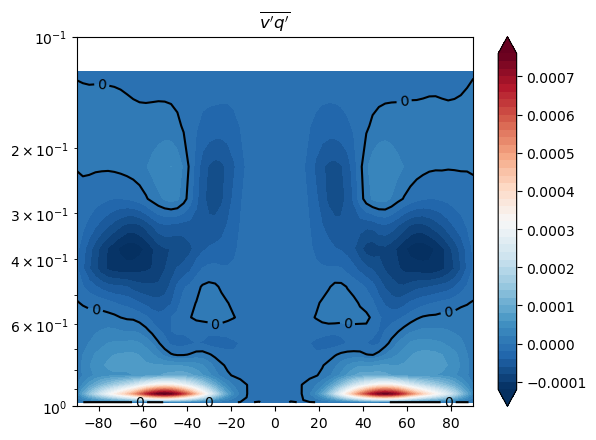

In [102]:
plt.figure()
plt.yscale('log')
plt.gca().invert_yaxis()
CS = plt.contourf(yy, sigma_mean2,  vq_50_10_mean , levels=51, cmap="RdBu_r", extend="both")
CT = plt.contour(yy, sigma_mean2,  vq_50_10_mean ,[0.0], colors='k')
plt.clabel(CT)
plt.ylim([1,0.1])
plt.colorbar(CS)
plt.title("$\overline{v'q'}$")

In [103]:
# q2[q2 == inf] = np.nan
vq_final = q2 + dmdy
vq_final_reshape = np.reshape(vq_final,(500,20*64))

vq_final_mean  = np.nanmean(vq_final_reshape, axis=0)
vq_final_minus = vq_final_reshape - vq_final_mean
print(np.isnan(q2).sum())


print(vq_final_reshape.shape)
print(vq_final_mean.shape)
print(vq_final_minus.shape)
print(vq_final_minus)

0
(500, 1280)
(1280,)
(500, 1280)
[[-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]
 [-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]
 [-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]
 ...
 [-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]
 [-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]
 [-9.59529511e-23 -3.91752738e-21 -1.27054942e-20 ... -4.18222518e-21
  -3.04402465e-22 -7.67623608e-22]]


In [104]:
x           = np.linspace(-180,180,128)
y           = np.linspace(-90,90,64)
xd          = np.deg2rad(x)
yd          = np.deg2rad(y)
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

In [105]:
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0:1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

MHF_new = np.zeros(((500,22,64)))

for i in range(500):
    for j in range(64):
        fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
        MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF = np.zeros(((500,20,64))) # vertical heat flux
H = 6800
for i in range(1,20-1):
    # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    VHF[:,i,:] = (MHF[:,i+1,:] - MHF[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(2)) 
print(VHF.shape)
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
(500, 20, 64)


Text(0.5, 1.0, "$\\overline{v'b'} / N^2$")

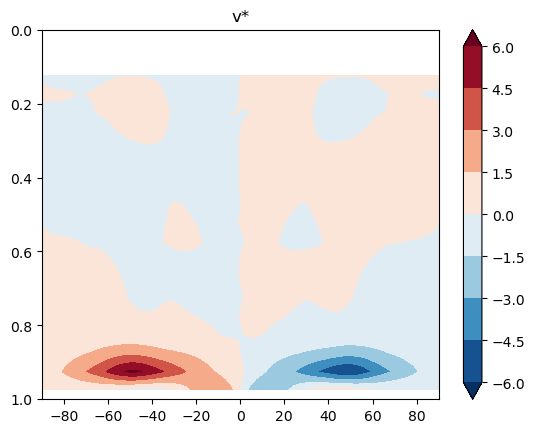

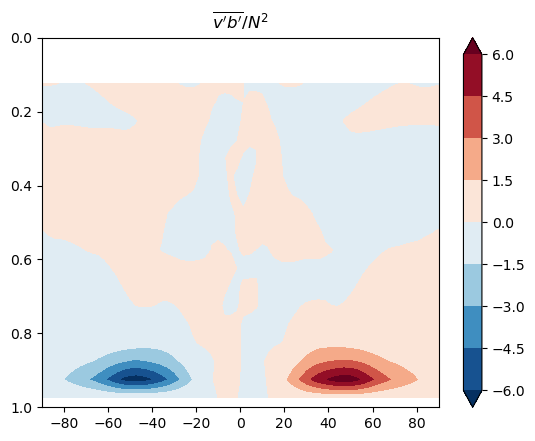

In [106]:



###################################
v_w   = np.zeros(v.shape)
VHF_w = np.zeros(VHF.shape)

# for i in range(1,64-1):
#     v_w[:,:,i]   = v[:,:,i] * cy[i] ** 0.5
#     VHF_w[:,:,i] = VHF[:,:,i] * cy[i] ** 0.5
    
v_star = np.nanmean(v, axis=3) - VHF
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(v_star, axis=(0)), levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.colorbar()
plt.title("v*")

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(VHF, axis=0), levels=12, cmap="RdBu_r", extend="both")
# plt.contourf(yy, sigma_mean2,  arr2, levels=12, cmap="RdBu_r", extend="both")

plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'} / N^2$")

(1280,)
(500, 1280)
(500, 1280)
[-5.51433355e-01 -1.01872960e+00  5.57164380e-02  1.45560192e+00
  1.55691838e+00  1.15769348e+00  5.46094118e-01 -9.93448610e-01
 -1.11903307e-01 -2.77543396e-02  2.27240501e-01  7.61664900e-02
 -4.56893820e-01 -7.24250469e-01 -4.77342748e-01 -8.35371937e-01
 -5.78773185e-01  6.74595881e-01  1.42335380e+00  3.32548593e-01
 -1.18541166e+00 -3.17864099e-02  7.36148169e-02  3.92762361e-01
 -7.00966197e-01 -1.61822670e-01 -1.34663008e+00 -5.81612564e-02
 -1.44750977e-01 -1.60919573e+00 -1.34120424e+00 -2.34134806e-01
  2.08882666e-01 -5.25249977e-01 -6.55545067e-01  2.26559715e+00
  1.54879547e+00 -1.62136870e-01  2.96551789e-02 -5.64818786e-01
 -8.41586528e-01  8.59623157e-01  5.96875534e-01 -1.84376081e+00
 -1.56926413e+00 -1.52707945e+00 -2.11470200e-01 -1.25949169e+00
 -7.83555262e-01 -6.51970155e-01  3.89994139e-02  3.76830187e-01
  8.28607692e-01  6.95745111e-01  1.69445729e+00  1.15971892e+00
 -1.23272497e+00  1.44766090e-01 -1.39531178e+00 -6.573155

/Users/Shared/miniconda3/envs/default_env2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/8s/brsznn615gb41jlx1d2lp59m0000gt/T/ipykernel_70547/32149321.py:51: RuntimeWarning: invalid value encountered in add
  m_right = f0v_star_reshape + vq_final_reshape
/var/folders/8s/brsznn615gb41jlx1d2lp59m0000gt/T/ipykernel_70547/32149321.py:52: RuntimeWarning: Mean of empty slice
  m_right_final = m_right - np.nanmean(m_right, axis=0)


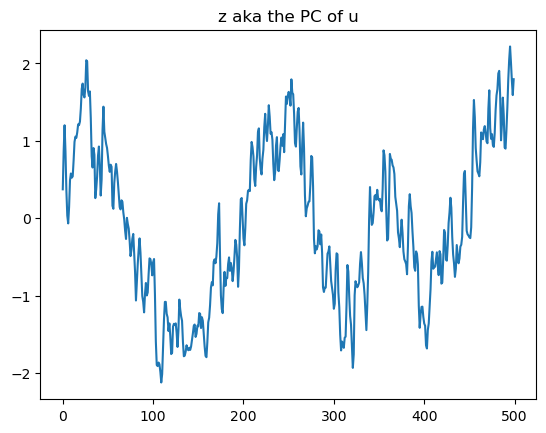

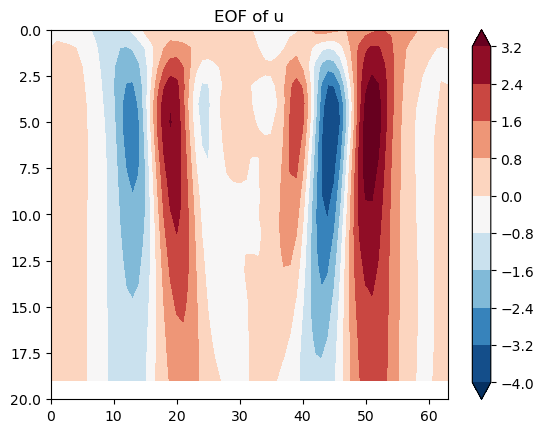

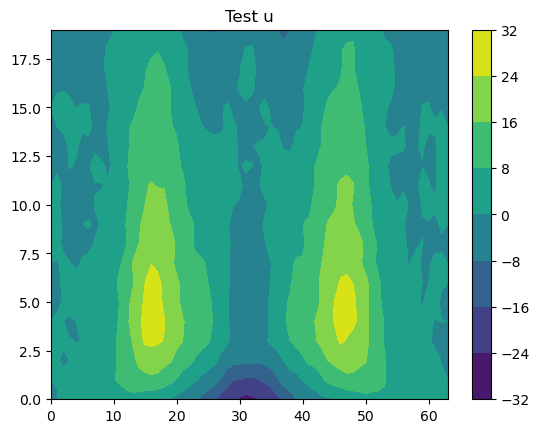

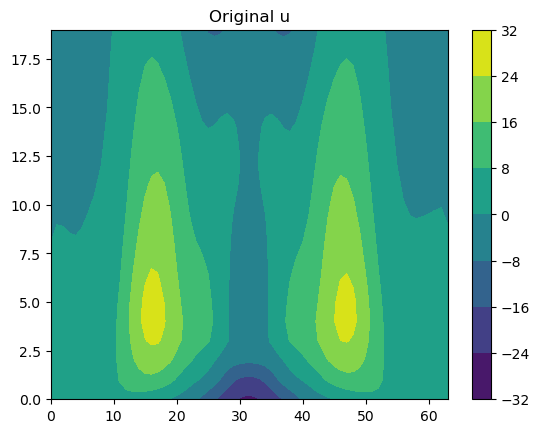

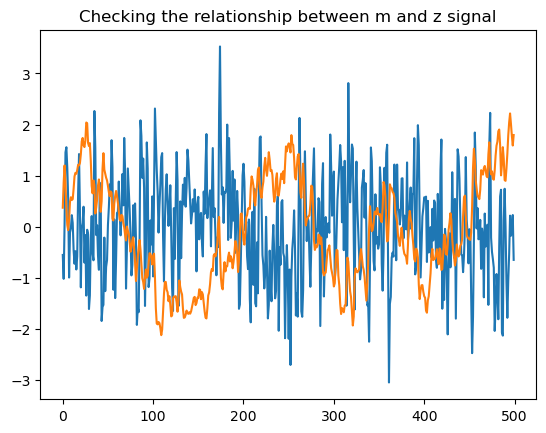

In [107]:
# Before EOF, we need to normalize final_m_term
from EOF import EOF
from scipy.fft import fft, ifft

u_50   = dycore.getVar("grid_u_c_xyzt")
u_50_w = np.zeros(u_50.shape)
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    u_50_w[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50_w2   = np.nanmean(u_50_w[:,:,:,:], axis=(3))
u_50_new  = np.reshape(u_50_w2, (500, 20*64))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new,), n_components=500, field="1D")
single_EOF_50.get()

z_paper       = (single_EOF_50.PC[0,:])
EOF_try       = (single_EOF_50.EOF[0,:])

z_paper_std   = z_paper.std()
z_paper_final = z_paper / z_paper_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

plt.figure()
plt.plot(z_paper_final)
plt.title("z aka the PC of u") 


EOF_std = EOF_try.std()
EOF_try = EOF_try * z_paper_std 
EOF_back = np.reshape(EOF_try, (20,64))
plt.figure()
plt.contourf(EOF_back, levels=11, cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([20,0])
plt.title("EOF of u") 

print(EOF_try.shape)
print(vq_final_minus.shape)
# m = np.dot(EOF_try[3:-3], vq_final_minus[:,3:-3].T)
f0v_star = np.zeros(((500,20,64)))
for i in range(64):
    f0v_star[:,:,i] = v_star[:,:,i] * f0[i]
f0v_star_reshape = np.reshape(f0v_star, (500,20*64))
f0v_star_minus   = f0v_star_reshape - np.nanmean(f0v_star_reshape, axis=0)
print(f0v_star_minus.shape)
# m_right = f0v_star_minus + vq_final_minus
m_right = f0v_star_reshape + vq_final_reshape
m_right_final = m_right - np.nanmean(m_right, axis=0)
############
# f0Vzm   = np.zeros(((500,20,64)))
# f0Vzm_w = np.zeros(((500,20,64)))

# # for i in range(64):
# #     f0Vzm[:,:,i]    = Vzm[:,:,i]  * f0[i]
# # for i in range(1,64-1):
# #     f0Vzm_w[:,:,i]  = f0Vzm[:,:,i]  * cy[i]**0.5
    
# f0Vzm_reshape       = np.reshape(Vzm, (500,20*64))
# f0Vzm_reshape_minus = f0Vzm_reshape - np.nanmean(f0Vzm_reshape, axis=0)
#### original ####
m = np.zeros(500)
for i in range(500):
    m[i] = np.nansum(EOF_try[2:-2]*m_right_final[i,2:-2].T)
##################
# m = np.zeros(500)
# for i in range(500):
#     m[i] = np.nansum(EOF_try[2:-2]*f0Vzm_reshape_minus[i,2:-2].T)

# m = m * 30 * 86400 /np.pi
m_std   = m.std()
m_final = m / m_std
print(m_final)

print(np.std(m_final))
plt.figure()
test = (single_EOF_50.EOF.T.dot(single_EOF_50.PC)).T
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
CS1 = plt.contourf(test_final)

plt.title("Test u") 
plt.colorbar(CS1)

plt.figure()
u_50_new_mean = np.nanmean(u_50_new, axis=0)
u_50_new_final = np.reshape(u_50_new_mean, (20,64))
CS2 = plt.contourf(u_50_new_final)
plt.title("Original u") 
plt.colorbar(CS2)


plt.figure()
plt.title("Checking the relationship between m and z signal") 
print(m_final.shape, z_paper_final.shape)
plt.plot(m_final)
plt.plot(z_paper_final)


In [78]:
file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
(500, 20, 64)


(1280,)
(500, 1280)
(500,) (500,)


/var/folders/8s/brsznn615gb41jlx1d2lp59m0000gt/T/ipykernel_70547/827558813.py:45: RuntimeWarning: invalid value encountered in add
  m_right = f0v_star_reshape + vq_final_reshape
/var/folders/8s/brsznn615gb41jlx1d2lp59m0000gt/T/ipykernel_70547/827558813.py:46: RuntimeWarning: Mean of empty slice
  m_right_final = m_right - np.nanmean(m_right, axis=0)


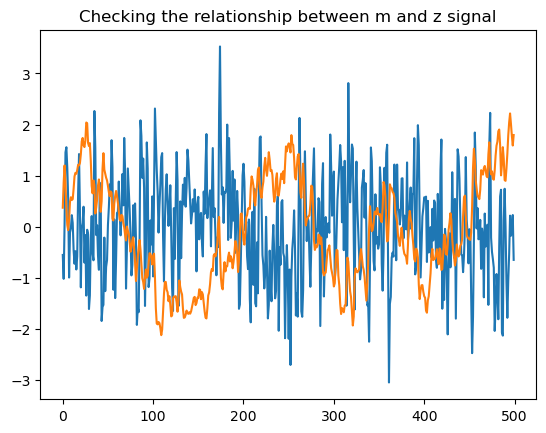

(0.02909333587719052+0.04084404291898146j)
(0.0338243637506206+0.004480778073361809j)
[-0.10674986+0.j         -1.39749512-0.35118192j -0.14472778-1.23302935j
 -2.72886245-3.5467089j   9.14955655-4.41769084j -0.72576722-1.83238424j
  2.89315435+8.8303673j  -4.67571526-3.85545231j  1.45813097-0.55066374j
 -3.53198679+1.24789203j -2.84429373+0.j         -3.53198679-1.24789203j
  1.45813097+0.55066374j -4.67571526+3.85545231j  2.89315435-8.8303673j
 -0.72576722+1.83238424j  9.14955655+4.41769084j -2.72886245+3.5467089j
 -0.14472778+1.23302935j -1.39749512+0.35118192j]


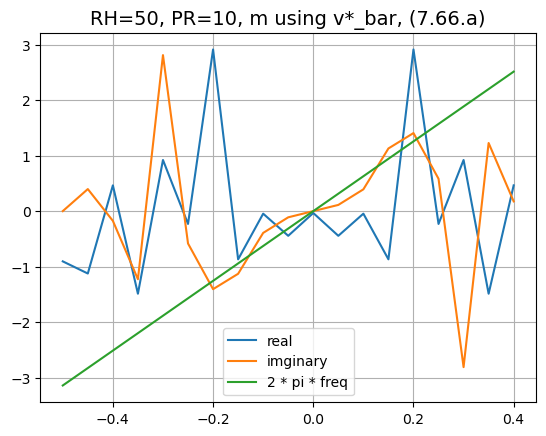